# 1. 1D example (training, inference, posterior sampling)

$\begin{align}
    f_{simulator}\colon\mathbb{R}^{N\times D} &\to\mathbb{R}^{N} \\
    X &\mapsto \mathbf{y}
\end{align}$

In [1]:
import numpy as np
import torch

In [2]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling


<br/>

**1D function example**: Forrester et al. (2008)

$f(x) = (6x - 2)^2 \sin(12x - 4)$

<br/>


In [3]:
# function to learn (normally a high-dimensional, expensive deterministic model)
from GPErks.utils.test_functions import forrester
f = lambda x: forrester(x)
D = 1

In [4]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset.build_from_function(
    f,
    D,
    n_train_samples=10,
    n_test_samples=10,
    design="srs",
    seed=seed,
    l_bounds=[0],
    u_bounds=[1]  # can put None if, as in this case, parameters range in [0, 1]
)

<br/>

**Gaussian process emulator (GPE):**
<br/>

$f(\mathbf{x}) = h(\mathbf{x}) + g(\mathbf{x})$

<br/>

**deterministic part:**
<br/>

$h(\mathbf{x}) := \beta_0 + \beta_1 x_1 + \dots + \beta_{D} x_{D}$

<br/>

**stochastic part:**
<br/>

$\begin{align}
    &g(\mathbf{x})\sim\mathcal{GP}(\mathbf{0},\,k_{\text{SE}}(d(\mathbf{x},\,\mathbf{x}'))) \\
    &k_{\text{SE}}(d(\mathbf{x},\,\mathbf{x}')) := \sigma_f^2\, e^{-\frac{1}{2}\,d(\mathbf{x},\,\mathbf{x}')} \\
    &d(\mathbf{x},\,\mathbf{x}') := (\mathbf{x}-\mathbf{x}')^\mathsf{T}\,\Lambda\,(\mathbf{x}-\mathbf{x}')
\end{align}$

<br/>

**likelihood:**
<br/>

$y=f(\mathbf{x}) + \varepsilon,\quad \varepsilon\sim\mathcal{N}(0,\,\sigma_n^2)$

<br/>


In [5]:
# choose likelihood
from gpytorch.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood()

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# choose mean function
from gpytorch.means import LinearMean
mean_function = LinearMean(input_size=dataset.input_size)

In [7]:
# choose covariance function (kernel)
from gpytorch.kernels import RBFKernel, ScaleKernel
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))

In [8]:
# choose metrics
from torchmetrics import MeanSquaredError, R2Score
metrics = [MeanSquaredError(), R2Score()]

In [9]:
# define experiment
from GPErks.gp.experiment import GPExperiment
experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,  # reproducible training
    learn_noise=True  # y = f(x) + e, e ~ N(0, sigma^2I)
)

In [10]:
# choose training options: device + optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

In [11]:
# train model
from GPErks.train.emulator import GPEmulator
emulator = GPEmulator(experiment, device)
emulator.train(optimizer)

INFO:2025-05-16 16:24:31,633:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:24:31,634:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:24:31,662:emulator:_train_once:L303: [  1/100] Training Loss: 1.6861 - MeanSquaredError: 0.8620 - R2Score: 0.1380
INFO:2025-05-16 16:24:31,666:emulator:_train_once:L303: [  2/100] Training Loss: 1.6591 - MeanSquaredError: 0.8447 - R2Score: 0.1553
INFO:2025-05-16 16:24:31,669:emulator:_train_once:L303: [  3/100] Training Loss: 1.6330 - MeanSquaredError: 0.8289 - R2Score: 0.1711
INFO:2025-05-16 16:24:31,673:emulator:_train_once:L303: [  4/100] Training Loss: 1.6080 - MeanSquaredError: 0.8145 - R2Score: 0.1855
INFO:2025-05-16 16:24:31,676:emulator:_train_once:L303: [  5/100] Training Loss: 1.5840 - MeanSquaredError: 0.

(OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-10.7605])),
              ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
               tensor(1.0000e-04)),
              ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
               tensor(inf)),
              ('mean_module.weights', tensor([[2.9474]])),
              ('mean_module.bias', tensor([-1.0693])),
              ('covar_module.raw_outputscale', tensor(1.7124)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[-1.6003]])),
              ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
               tensor(inf)),
              ('covar_module.raw_outputscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.raw_outputscale_constraint.upper_bound',
               tensor(inf))]),
 <GPErks.train.train_

In [12]:
# inference on stored test set
x_test = dataset.X_test
y_test = dataset.y_test

y_mean, y_std = emulator.predict(x_test)

for metric in metrics:
    print( metric(
        torch.from_numpy(y_mean), torch.from_numpy(y_test)
        ).item()
    )

0.2552940845489502
0.8388684249013869


In [13]:
# perk n.1: automatic inference
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()  # can be retrieved from inference.scores_dct
print( inference.scores_dct )

                   Score
MeanSquaredError  0.2553
R2Score           0.8389
{'MeanSquaredError': array(0.25529402, dtype=float32), 'R2Score': array(0.83886844, dtype=float32)}


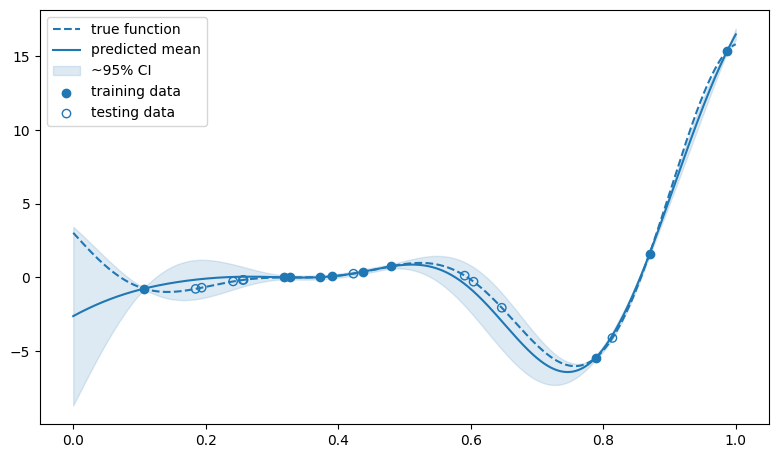

In [14]:
# nice plotting
x_train = dataset.X_train
y_train = dataset.y_train

xx = np.linspace(dataset.l_bounds[0], dataset.u_bounds[0], 1000)
yy_mean, yy_std = emulator.predict(xx)
yy_true = f(xx)

import matplotlib.pyplot as plt
height = 9.36111
width = 5.91667
fig, axis = plt.subplots(1, 1, figsize=(4*width/3, height/2))

axis.plot(xx, yy_true, c="C0", ls="--", label="true function")

CI = 2
axis.plot(xx, yy_mean, c="C0", label="predicted mean")
axis.fill_between(
    xx, yy_mean - CI * yy_std, yy_mean + CI * yy_std, color="C0", alpha=0.15, label="~95% CI"
)
axis.scatter(x_train, y_train, fc="C0", ec="C0", label="training data")

axis.scatter(x_test, y_test, fc="none", ec="C0", label="testing data")

axis.legend(loc="best")
fig.tight_layout()
plt.show()

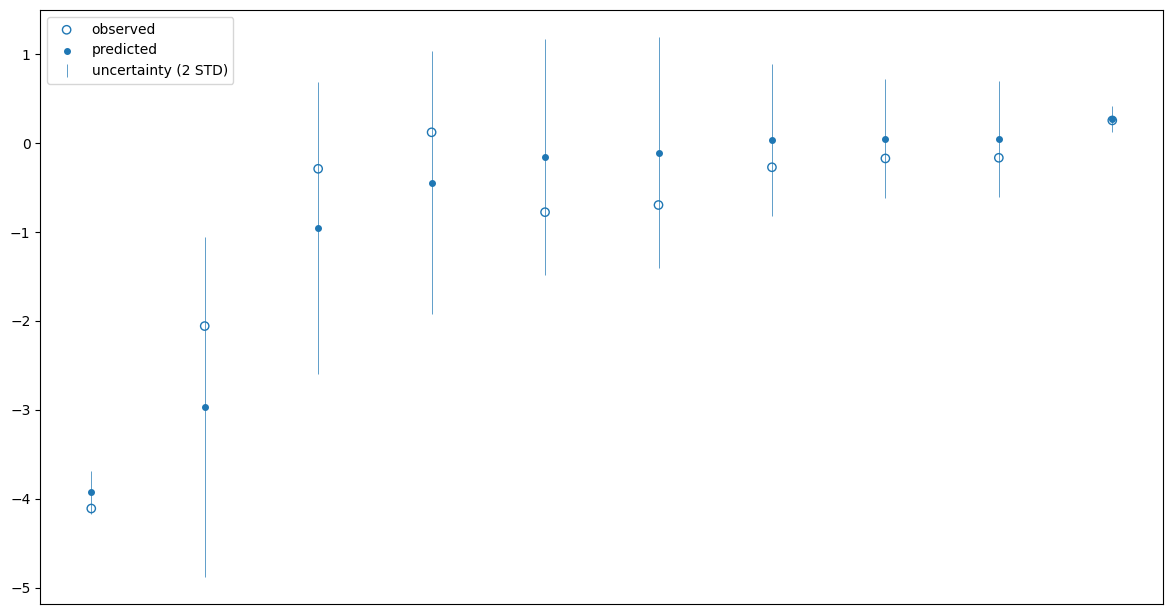

In [15]:
# check testing points
inference.plot()

In [16]:
# draw samples from the posterior distribution
y_mean, y_std = emulator.predict(x_test)
print(y_mean.shape)
print(y_std.shape)

(10,)
(10,)


In [17]:
y_samples = emulator.sample(x_test, n_draws=5)
print(y_samples.shape)

(5, 10)


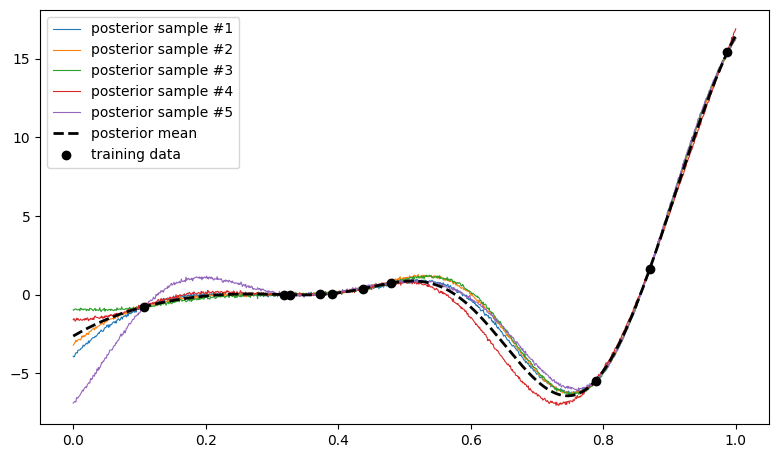

In [18]:
y_samples = emulator.sample(xx, n_draws=5)

fig, axis = plt.subplots(1, 1, figsize=(4*width/3, height/2))

for i, ys in enumerate(y_samples):
    axis.plot(xx, ys, lw=0.8, label=f"posterior sample #{i+1}", zorder=1)
    
axis.plot(xx, yy_mean, c="k", lw=2, ls="--", label="posterior mean", zorder=2)
axis.scatter(x_train, y_train, fc="k", ec="k", label="training data", zorder=2)

axis.legend(loc="best")
fig.tight_layout()
plt.show()